In [1]:
from importlib import reload
import sys, os
from copy import deepcopy
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import scipy as sp
import scipy.stats as st
print('scipy version %s' % sp.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
print('matplotlib version %s' % matplotlib.__version__)

python version 3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:21:42) [Clang 18.1.8 ]
numpy version 1.26.4
scipy version 1.14.1
pandas version 2.2.2
matplotlib version 3.9.3


In [2]:
SIMULATION_DIRECTORY = 'simulations'
DATA_DIRECTORY       = 'data'
SCRIPT_DIRECTORY     = ''
INFERENCE_DATE       = '2022-06-09'
SARS_DATA_DIR        = os.path.join(os.getcwd(), DATA_DIRECTORY)

# Paper figures

In [3]:
# Figure 1 -- inference results for simulations

import figs as f
reload(f)

data = { 'sim_file':       os.path.join(SIMULATION_DIRECTORY, 'sim-init-sample50-T50.npz'),
         'inf_file':       os.path.join(SIMULATION_DIRECTORY, 'inf-init-sample50-T50.npz'),
         'replicate_file': os.path.join(SIMULATION_DIRECTORY, 'epi-init-sample50-T50.npz'),
         'pop_size':       10000,
         'cutoff':         0.01 }

f.plot_performance(**data)

In [ ]:
df = pd.read_csv('data/phenotype-table-new.csv')

var_cols = ['Epsilon', 'Alpha', 'Beta', 'Lambda', 'Gamma', 'Mu', 'Delta', 
            'BA.1', 'BA.2', 'BA.4', 'BA.5', 'XBB', 'XBB.1.5', 'EG.5.1', 'BA.2.86', 'JN.1']

for idx, entry in df.iterrows():
    for v in var_cols:
        var_list = list(str(entry['Associated variants']).split())
        if v in var_list or df.at[idx, v]==True:
            df.at[idx, v] = True
        else:
            if v=='BA.2' and (('BA.2.12.1' in var_list) or ('BA.2.75' in var_list)):
                df.at[idx, v] = True
            else:
                df.at[idx, v] = False

df.to_csv('data/phenotype-table-new-corrected.csv', index=False)

In [4]:
# Figure 2 -- aggregate statistics for inferred coefficients

import figs as f
reload(f)
        
data = { 'selection_file_all': os.path.join(SARS_DATA_DIR, 'selection-nonsyn-corrected.csv'),
         'selection_file_ns':  os.path.join(SARS_DATA_DIR, 'selection-nonsyn-corrected.csv'),
         'mutation_file':      os.path.join(SARS_DATA_DIR, 'phenotype-table-new-corrected.csv'),
         'label2ddr':          { 'NSP1':  0.01,
                                 'NSP2':  0.02,
                                 'NSP7':  0.09,
                                 'NSP13': 0.03,
                                 'E':     0.09,
                                 'ORF6':  0.12,
                                 'ORF7a': 0.09,
                                 'ORF7b': 0.08,
                                 'ORF8':  0.03,
                                 'ORF10': 0.01 } }

f.plot_selection_statistics_mutations(**data)

In [5]:
# Selection coefficients and ranks for specific mutations

df = pd.read_csv(os.path.join(SARS_DATA_DIR, 'selection-nonsyn-paper.csv'), memory_map=True)

print('We estimate selection coefficients for %d nonsynonymous single nucleotide variants\n' % len(df))

df = pd.read_csv(os.path.join(SARS_DATA_DIR, 'selection-nonsyn-corrected.csv'), memory_map=True)

names = ['NSP6:d106', 'NSP6:d107', 'NSP6:d108', 'S:E484K ', 'S:S477N ', 'S:N501Y ', 'S:D614G ', 'N:R203M ']
idxs  = [      11288,       11291,       11294,      23012,      22992,      23063,      23403,      28881]
nucs  = [        '-',         '-',         '-',        'A',        'A',        'T',        'G',        'T']

names = names + ['N:T205I ', 'N:S202N ', 'N:S202R ', 'ORF7a:T120I', 'M:I82T  ', 'S:A222V ']
idxs  = idxs  + [     28887,      28878,      28879,         27752,      26767,      22227]
nucs  = nucs  + [       'T',        'A',        'G',           'T',        'C',        'T']

print('name\t\ts\trank')
for i in range(len(names)):
    df_temp = df[(df['nucleotide number']==str(idxs[i])) & (df['nucleotide']==nucs[i])]
    if len(df_temp)>0:
        print('%s\t%.3f\t%d' % (names[i], df_temp.iloc[0]['selection coefficient'], 
                                1 + np.sum(df['selection coefficient']>df_temp.iloc[0]['selection coefficient'])))

topx  = 5
order = np.argsort(np.array(df['selection coefficient']))[::-1] 
print('\nname\t\ts\trank')
for i in range(topx):
    df_temp = df.iloc[order[i]]
    name = df_temp['protein']+':'+df_temp['amino acid mutation'].split('>')[0]+df_temp['amino acid number in protein'] \
           +df_temp['amino acid mutation'].split('>')[1]
    if len(name)<9:
        name = name+'\t'
    print('%s\t%.3f\t%d' % (name, df_temp['selection coefficient'], i+1))

We estimate selection coefficients for 1259 nonsynonymous single nucleotide variants

name		s	rank
NSP6:d106	0.165	3
NSP6:d107	-0.010	1172
NSP6:d108	0.013	240
S:E484K 	0.039	73
S:S477N 	0.046	60
S:N501Y 	0.101	15
S:D614G 	0.017	181
N:R203M 	0.114	13
N:T205I 	0.004	492
N:S202N 	0.020	155
N:S202R 	0.004	550
ORF7a:T120I	0.009	312
M:I82T  	0.041	70
S:A222V 	0.026	120

name		s	rank
S:F486L		0.169	1
NSP4:T492I	0.166	2
NSP6:S106-	0.165	3
S:Q498R		0.162	4
S:Q954H		0.140	5


In [6]:
# Figure 3 -- selection and trajectories for variants

import figs as f
reload(f)

data = { 'variant_file':    os.path.join(SARS_DATA_DIR, 'linked-coefficients.csv'),
         'trajectory_file': os.path.join(SARS_DATA_DIR, 'trajectories.csv'),
         'variant_list':    ['alpha', 'delta', 'gamma', 'BA.1', 'BA.2', 'XBB', 'JN.1'], #, 'BA.2.86'],
         'variant_names':   ['Alpha', 'Delta', 'Gamma', 'Omicron (BA.1)', 'BA.2', 'XBB', 'JN.1'], #, 'BA.2.86'],
         's_cutoff':        0.05,
         'h_relative':      1/1.1,
         'time_set':        'current',
         'filename':        'fig-3' }

f.plot_variant_selection(**data)

variant	w
JN.1	3.355
XBB	2.802
BA.2	2.127
BA.1	1.702
delta	0.850
gamma	0.423
alpha	0.328
JN.1	0.021
XBB	0.021
BA.2	0.021
Omicron (BA.1)	0.017
Delta	0.026
Gamma	0.011
Alpha	0.007


In [7]:
# Figure 4 -- selection over time for the first major VOCs

import figs as f
reload(f)

data = { 'alpha_file':           os.path.join(SARS_DATA_DIR, 'alpha-tv-s-gb.csv'),
         'alpha_file_subdate':   os.path.join(SARS_DATA_DIR, 'alpha-tv-s-gb-subdate.csv'),
         'alpha_start':          310,
         'alpha_end':            310+57,
         'delta_file':           os.path.join(SARS_DATA_DIR, 'delta-tv-s-gb.csv'),
         'delta_file_subdate':   os.path.join(SARS_DATA_DIR, 'delta-tv-s-gb-subdate.csv'),
         'delta_start':          462,
         'delta_end':            462+57,
         'omicron_file':         os.path.join(SARS_DATA_DIR, 'omicron-tv-s-south-africa.csv'),
         'omicron_file_subdate': os.path.join(SARS_DATA_DIR, 'omicron-tv-s-south-africa-subdate.csv'),
         'omicron_start':        653,
         'omicron_end':          653+57 }

f.plot_frequency_selection(**data)

In [ ]:
# Figure 4 -- early detection

import figs as f
reload(f)

data = { #'alpha_file':           os.path.join(SARS_DATA_DIR, 'alpha-tv-s-gb.csv'),
         'alpha_file_subdate':   os.path.join(SARS_DATA_DIR, 'alpha-tv-s-gb-subdate.csv'),
         'alpha_start':          308,
         'alpha_end':            308+57,
         #'delta_file':           os.path.join(SARS_DATA_DIR, 'delta-tv-s-gb.csv'),
         'delta_file_subdate':   os.path.join(SARS_DATA_DIR, 'delta-tv-s-gb-subdate.csv'),
         'delta_start':          456,
         'delta_end':            456+57,
         #'omicron_file':         os.path.join(SARS_DATA_DIR, 'omicron-tv-s-south-africa.csv'),
         'omicron_file_subdate': os.path.join(SARS_DATA_DIR, 'omicron-tv-s-south-africa-subdate.csv'),
         'omicron_start':        665,
         'omicron_end':          665+57,
         's_cutoff':             0.140 }

f.plot_early_detection_sub(**data)

# Supplementary Figures

In [ ]:
# Variables

import epi_figs as ef

seq_ref = 'data/genome-filtered/europe-united kingdom-england_wales_scotland-2020-10-31-2020-12-14---2020-10-31-2020-12-14.csv'
map_ref = 'data/genome-filtered/europe-united kingdom-england_wales_scotland-2020-10-31-2020-12-14---2020-10-31-2020-12-14-sites.csv'
var_ref = 'data/variant-mutations.csv'
var_nam = 'Alpha'
t_detect = 332
verbose = False

nuc = ef.NUC
var_frc = 0.8

t_latest = 0  # Look at sequences collected within X days of the latest
dt = 14        

n_latest = 100  # ALT: Look at the latest X sequences as of the detection day

seqs = []
dates = []


# Read in variant mutations

df_var = pd.read_csv(var_ref)
df_var = df_var[df_var[var_nam]==True]
n_muts = len(df_var)
mut_list = list(df_var['mutation'])
var_cutoff = int(var_frc * n_muts)


# Read in sequences and get ones within dt of the most recently submitted sequence at the time of detection

df_seq = pd.read_csv(seq_ref)
df_seq = df_seq[df_seq['submission_date']<=t_detect]

t_latest  = np.max(df_seq['date'])
df_latest = df_seq[df_seq['date']>=t_latest-dt]

for i in range(len(df_latest)):
    seqs.append(str(df_latest.iloc[i]['sequence']))
    dates.append(int(df_latest.iloc[i]['date']))

print('Searching for %s sequences among sequences within %d days of the most recent sequence at time %d before the detection time %d' % (var_nam, dt, t_latest, t_detect))
print('%d variant-defining mutations in total, classified as variant for >=%d mutations\n' % (n_muts, var_cutoff))


# ALT: Read in sequences and get the n_latest most recently submitted as of the detection time

# df_seq = pd.read_csv(seq_ref)
# df_seq = df_seq[df_seq['submission_date']<=t_detect]

# t_sort = np.argsort(np.array(df_seq['date'], int))[::-1]

# for i in range(n_latest):
#     seqs.append(str(df_seq.iloc[t_sort[i]]['sequence']))
#     dates.append(int(df_seq.iloc[t_sort[i]]['date']))

# print('Searching for %s sequences among last %d sequences collected before the detection time %d' % (var_nam, n_latest, t_detect))
# print('%d variant-defining mutations in total, classified as variant for >=%d mutations\n' % (n_muts, var_cutoff))


# Read in the site map

df_map = pd.read_csv(map_ref)
map_sites = np.array(df_map['ref_sites'])


# Iterate through sequences and determine the number of Alpha mutations in each sequence

if verbose:
    print('variant\tdate\tmutations')

is_var = []
for i in range(len(seqs)):
    s = seqs[i]
    var_muts = 0
    for j in range(len(s)):
        nuc_id = str(map_sites[j]) + '-' + nuc[int(s[j])]
        if nuc_id in mut_list:
            var_muts += 1
    if var_muts >= var_cutoff:
        is_var.append(1)
    else:
        is_var.append(0)
    if verbose:    
        print('%s\t%d\t%d' % (var_nam, dates[i], var_muts))

if verbose:
    print('')
print('%d out of %d (%.2f%%) sequences classified as variant' % (np.sum(is_var), len(is_var), 100*np.sum(is_var)/len(is_var)))

In [ ]:
print('COMBINE THESE RESULTS WITH PREVIOUS DATA BLOCK AND HARDCODED t_latest TO ESTIMATE FREQUENCIES FOR DELTA')

# Variables

import epi_figs as ef

nuc = ef.NUC

seq_ref = 'data/genome-filtered/europe-united kingdom-england_wales_scotland-2021-04-22-2021-05-31---2021-4-22-2021-5-31.csv'
map_ref = 'data/genome-filtered/europe-united kingdom-england_wales_scotland-2021-04-22-2021-05-31---2021-4-22-2021-5-31-sites.csv'
var_ref = 'data/variant-mutations.csv'
var_nam = 'Delta'
t_detect = 488
verbose = False

nuc = ef.NUC
var_frc = 0.8

t_latest = 0  # Look at sequences collected within X days of the latest
dt = 14        

n_latest = 100  # ALT: Look at the latest X sequences as of the detection day

seqs = []
dates = []


# Read in variant mutations

df_var = pd.read_csv(var_ref)
df_var = df_var[df_var[var_nam]==True]
n_muts = len(df_var)
mut_list = list(df_var['mutation'])
var_cutoff = int(var_frc * n_muts)


# Read in sequences and get ones within dt of the most recently submitted sequence at the time of detection

df_seq = pd.read_csv(seq_ref)
df_seq = df_seq[df_seq['submission_date']<=t_detect]

t_latest  = np.max(df_seq['date'])
df_latest = df_seq[df_seq['date']>=t_latest-dt]

for i in range(len(df_latest)):
    seqs.append(str(df_latest.iloc[i]['sequence']))
    dates.append(int(df_latest.iloc[i]['date']))

print('Searching for %s sequences among sequences within %d days of the most recent sequence at time %d before the detection time %d' % (var_nam, dt, t_latest, t_detect))
print('%d variant-defining mutations in total, classified as variant for >=%d mutations\n' % (n_muts, var_cutoff))


# ALT: Read in sequences and get the n_latest most recently submitted as of the detection time

# df_seq = pd.read_csv(seq_ref)
# df_seq = df_seq[df_seq['submission_date']<=t_detect]

# t_sort = np.argsort(np.array(df_seq['date'], int))[::-1]

# for i in range(n_latest):
#     seqs.append(str(df_seq.iloc[t_sort[i]]['sequence']))
#     dates.append(int(df_seq.iloc[t_sort[i]]['date']))

# print('Searching for %s sequences among last %d sequences collected before the detection time %d' % (var_nam, n_latest, t_detect))
# print('%d variant-defining mutations in total, classified as variant for >=%d mutations\n' % (n_muts, var_cutoff))


# Read in the site map

df_map = pd.read_csv(map_ref)
map_sites = np.array(df_map['ref_sites'])


# Iterate through sequences and determine the number of Alpha mutations in each sequence

if verbose:
    print('variant\tdate\tmutations')

is_var = []
for i in range(len(seqs)):
    s = seqs[i]
    var_muts = 0
    for j in range(len(s)):
        nuc_id = str(map_sites[j]) + '-' + nuc[int(s[j])]
        if nuc_id in mut_list:
            var_muts += 1
    if var_muts >= var_cutoff:
        is_var.append(1)
    else:
        is_var.append(0)
    if verbose:    
        print('%s\t%d\t%d' % (var_nam, dates[i], var_muts))

if verbose:
    print('')
print('%d out of %d (%.2f%%) sequences classified as variant' % (np.sum(is_var), len(is_var), 100*np.sum(is_var)/len(is_var)))

In [ ]:
# Variables

import epi_figs as ef

nuc = ef.NUC

seq_ref = 'data/genome-filtered/europe-united kingdom-england_wales_scotland-2021-03-21-2021-04-22---2021-3-21-2021-4-22.csv'
map_ref = 'data/genome-filtered/europe-united kingdom-england_wales_scotland-2021-03-21-2021-04-22---2021-3-21-2021-4-22-sites.csv'
var_ref = 'data/variant-mutations.csv'
var_nam = 'Delta'
t_detect = 488
verbose = False

nuc = ef.NUC
var_frc = 0.8

t_latest = 0  # Look at sequences collected within X days of the latest
dt = 14        

n_latest = 100  # ALT: Look at the latest X sequences as of the detection day

seqs = []
dates = []


# Read in variant mutations

df_var = pd.read_csv(var_ref)
df_var = df_var[df_var[var_nam]==True]
n_muts = len(df_var)
mut_list = list(df_var['mutation'])
var_cutoff = int(var_frc * n_muts)


# Read in sequences and get ones within dt of the most recently submitted sequence at the time of detection

df_seq = pd.read_csv(seq_ref)
df_seq = df_seq[df_seq['submission_date']<=t_detect]

t_latest  = 483
df_latest = df_seq[df_seq['date']>=t_latest-dt]

for i in range(len(df_latest)):
    seqs.append(str(df_latest.iloc[i]['sequence']))
    dates.append(int(df_latest.iloc[i]['date']))

print('Searching for %s sequences among sequences within %d days of the most recent sequence at time %d before the detection time %d' % (var_nam, dt, t_latest, t_detect))
print('%d variant-defining mutations in total, classified as variant for >=%d mutations\n' % (n_muts, var_cutoff))


# ALT: Read in sequences and get the n_latest most recently submitted as of the detection time

# df_seq = pd.read_csv(seq_ref)
# df_seq = df_seq[df_seq['submission_date']<=t_detect]

# t_sort = np.argsort(np.array(df_seq['date'], int))[::-1]

# for i in range(n_latest):
#     seqs.append(str(df_seq.iloc[t_sort[i]]['sequence']))
#     dates.append(int(df_seq.iloc[t_sort[i]]['date']))

# print('Searching for %s sequences among last %d sequences collected before the detection time %d' % (var_nam, n_latest, t_detect))
# print('%d variant-defining mutations in total, classified as variant for >=%d mutations\n' % (n_muts, var_cutoff))


# Read in the site map

df_map = pd.read_csv(map_ref)
map_sites = np.array(df_map['ref_sites'])


# Iterate through sequences and determine the number of Alpha mutations in each sequence

if verbose:
    print('variant\tdate\tmutations')

is_var = []
for i in range(len(seqs)):
    s = seqs[i]
    var_muts = 0
    for j in range(len(s)):
        nuc_id = str(map_sites[j]) + '-' + nuc[int(s[j])]
        if nuc_id in mut_list:
            var_muts += 1
    if var_muts >= var_cutoff:
        is_var.append(1)
    else:
        is_var.append(0)
    if verbose:    
        print('%s\t%d\t%d' % (var_nam, dates[i], var_muts))

if verbose:
    print('')
print('%d out of %d (%.2f%%) sequences classified as variant' % (np.sum(is_var), len(is_var), 100*np.sum(is_var)/len(is_var)))

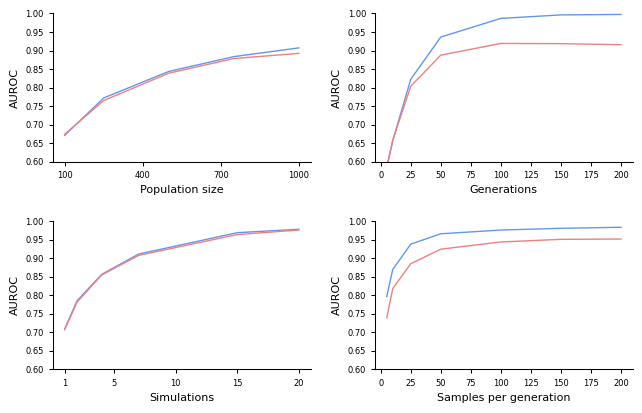

In [9]:
# Supplementary Figure 1 -- AUROC plots for various parameters 

import epi_figs as ef
reload(ef)

ef.auroc_plots_combined(os.path.join(SIMULATION_DIRECTORY, 'epi-init-sim'), 
                        os.path.join(SIMULATION_DIRECTORY, 'epi-init-T'), 
                        os.path.join(SIMULATION_DIRECTORY, 'epi-init-sample'), 
                        os.path.join(SIMULATION_DIRECTORY, 'epi-init-smallpop'))

In [10]:
# Figure S4 -- selection and trajectories for variants

import figs as f
reload(f)

data = { 'variant_file':    os.path.join(SARS_DATA_DIR, 'linked-coefficients.csv'),
         'trajectory_file': os.path.join(SARS_DATA_DIR, 'trajectories.csv'),
         'variant_list':    ['alpha', 'delta',           'BA.1', 'BA.2', 'BA.4', 'BA.5', 'JN.1', 'BA.2.86', 'XBB', 'XBB.1.5', 'EG.5.1', 'gamma', 'beta', 'lambda', 'epsilon', 'mu'],
         'variant_names':   ['Alpha', 'Delta', 'Omicron (BA.1)', 'BA.2', 'BA.4', 'BA.5', 'JN.1', 'BA.2.86', 'XBB', 'XBB.1.5',   'EG.5', 'Gamma', 'Beta', 'Lambda', 'Epsilon', 'Mu'],
         's_cutoff':        0.05,
         'h_relative':      1 * (16/7),
         'box_dims':        dict(left=0.08, right=0.95, bottom=0.07, top=0.98),
         'time_set':        'current',
         'filename':        'fig-s4-variants-full' }

f.plot_variant_selection(**data)

variant	w
JN.1	3.355
BA.2.86	3.273
EG.5.1	3.026
XBB.1.5	2.999
XBB	2.802
BA.5	2.543
BA.4	2.435
BA.2	2.127
BA.1	1.702
delta	0.850
mu	0.451
gamma	0.423
lambda	0.419
beta	0.357
alpha	0.328
epsilon	0.137
JN.1	0.021
BA.2.86	0.021
EG.5	0.022
XBB.1.5	0.022
XBB	0.021
BA.5	0.024
BA.4	0.020
BA.2	0.021
Omicron (BA.1)	0.017
Delta	0.026
Mu	0.015
Gamma	0.011
Lambda	0.009
Beta	0.010
Alpha	0.007
Epsilon	0.011


In [11]:
# Figure S6 -- precision

import figs as f
reload(f)

data = { 'detection_file': os.path.join(SARS_DATA_DIR, 'detection-summary.csv'),
         'fig_title':      'fig-s6-precision' }

f.plot_precision(**data)

In [ ]:
# Figure S7 -- early detection

import figs as f
reload(f)

data = { 'alpha_file':    os.path.join(SARS_DATA_DIR, 'alpha-tv-s-gb.csv'),
         'alpha_file_2':  os.path.join(SARS_DATA_DIR, 'alpha-tv-s-london.csv'),
         'alpha_start':   308,
         'alpha_end':     308+57,
         'delta_file':    os.path.join(SARS_DATA_DIR, 'delta-tv-s-gb.csv'),
         'delta_start':   456,
         'delta_end':     456+57,
         'omicron_file':  os.path.join(SARS_DATA_DIR, 'omicron-tv-s-south-africa.csv'),
         'omicron_start': 665,
         'omicron_end':   665+57 }

f.plot_early_detection_col(**data)

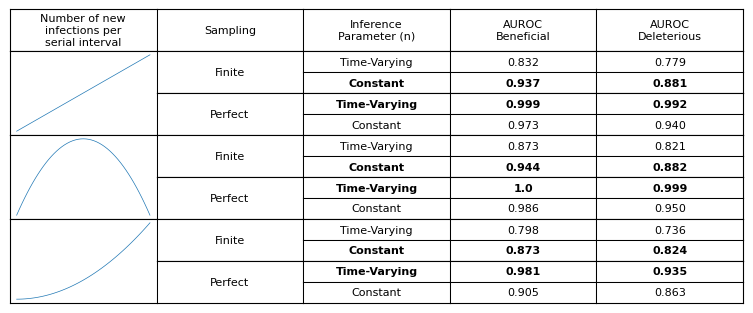

In [12]:
# Supplementary Figure 9 -- finite sampling and time-varying versus constant parameters

import epi_figs as ef
reload(ef)

rep_finite_dir = os.path.join(SIMULATION_DIRECTORY, 'replicates-finite')
rep_perfect_dir = os.path.join(SIMULATION_DIRECTORY, 'replicates-perfect')
ef.finite_sampling_plot(rep_finite_dir, rep_perfect_dir)

In [ ]:
# Supplementary Figure 10 -- sampling distributions in different regions

import epi_figs as ef
reload(ef)

sampling_dir = os.path.join(SARS_DATA_DIR, 'genome-filtered')
gen_dir      = os.path.join(SARS_DATA_DIR, 'genome-filtered-out')
ef.sampling_plots(sampling_dir, gen_dir, save_temp=False, log=True, out_file='fig-s12-sampling')

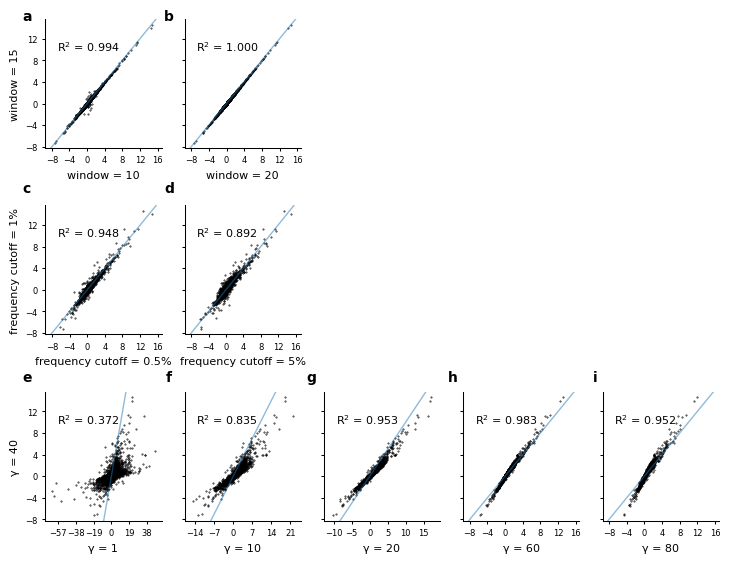

In [13]:
# Supplementary Figure 11 -- checks for how inferred coefficients change as various model or data analysis 
# parameters are changed

import epi_figs as ef
reload(ef)

inf_dir = os.path.join(SARS_DATA_DIR, 'sensitivity-data')
if not os.path.exists(inf_dir):
    os.mkdir(inf_dir)
file1   = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-40.npz')
file2   = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-1.npz')
file3   = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-10.npz')
file4   = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-20.npz')
file5   = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-60.npz')
file6   = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-80.npz')
files   = [file1, file2, file3, file4, file5, file6]
labels  = ['\u03B3 = 40', '\u03B3 = 1', '\u03B3 = 10', '\u03B3 = 20', '\u03B3 = 60', '\u03B3 = 80']

file_cut1 = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-40.npz')
file_cut2 = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-0.5pct.npz')
file_cut3 = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-5pct.npz')
files_cut = [file_cut1, file_cut2, file_cut3]
label_cut = ['frequency cutoff = 1%', 'frequency cutoff = 0.5%', 'frequency cutoff = 5%']

file_wind1 = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-40.npz')
file_wind2 = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-dt-10.npz')
file_wind3 = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-dt-20.npz')
files_wind = [file_wind1, file_wind2, file_wind3]
label_wind = ['window = 15', 'window = 10', 'window = 20']

reload(ef)
ef.s_compare_regs_cutoff_window(files_reg=files, labels_reg=labels, 
                                files_cutoff=files_cut, labels_cutoff=label_cut, 
                                files_wind=files_wind, labels_wind=label_wind,
                                out='fig-s13-sensitivity')

there are 410 selection coefficients


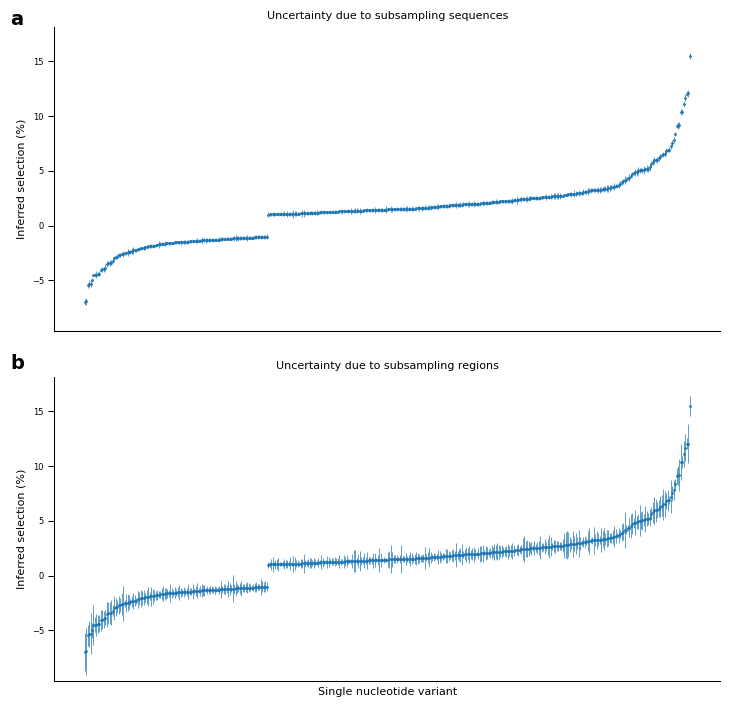

In [14]:
# Supplementary figure Y -- Plots of errors from subsampling regions and subsampling sequences

import epi_figs as ef
reload(ef)

bootstrap_file = os.path.join(SARS_DATA_DIR, 'selection-nonsyn-bootstrap.csv')
subsample_file = os.path.join(SARS_DATA_DIR, 'selection-nonsyn-subsample.csv')
ef.selection_error(bs_data=bootstrap_file, ss_data=subsample_file, out='fig-s14-uncertainty')

['N-3-1-C', 'N-3-2-T', 'N-3-3-A', 'N-235-2-T', 'NSP12-912-3-C', 'NSP12-613-3-T', 'NSP12-412-3-T', 'NSP2-36-3-T', 'NSP3-890-2-A', 'NSP3-183-2-T', 'NSP3-1412-2-C', 'NSP3-1089-3-T', 'ORF8-73-2-G', 'ORF8-52-2-T', 'ORF8-27-1-T', 'S-982-1-G', 'S-716-2-T', 'S-570-2-A', 'S-501-1-T', 'S-1118-1-C']
['N-3-1-C', 'N-3-2-T', 'N-3-3-A', 'N-235-2-T', 'NSP12-912-3-C', 'NSP12-613-3-T', 'NSP12-412-3-T', 'NSP2-36-3-T', 'NSP3-890-2-A', 'NSP3-183-2-T', 'NSP3-1412-2-C', 'NSP3-1089-3-T', 'ORF8-73-2-G', 'ORF8-52-2-T', 'ORF8-27-1-T', 'S-982-1-G', 'S-716-2-T', 'S-570-2-A', 'S-501-1-T', 'S-1118-1-C']
['M-82-2-C', 'N-63-2-G', 'N-377-1-T', 'N-203-2-T', 'NC-209-T', 'NSP12-671-1-A', 'NSP13-77-2-T', 'ORF3a-26-2-T', 'ORF7a-82-2-C', 'ORF7a-120-2-T', 'S-950-1-A', 'S-681-2-G', 'S-478-2-A', 'S-452-2-G', 'S-19-2-G']
['M-82-2-C', 'N-63-2-G', 'N-377-1-T', 'N-203-2-T', 'NC-209-T', 'NSP12-671-1-A', 'NSP13-77-2-T', 'ORF3a-26-2-T', 'ORF7a-82-2-C', 'ORF7a-120-2-T', 'S-950-1-A', 'S-681-2-G', 'S-478-2-A', 'S-452-2-G', 'S-19-2-G']
['

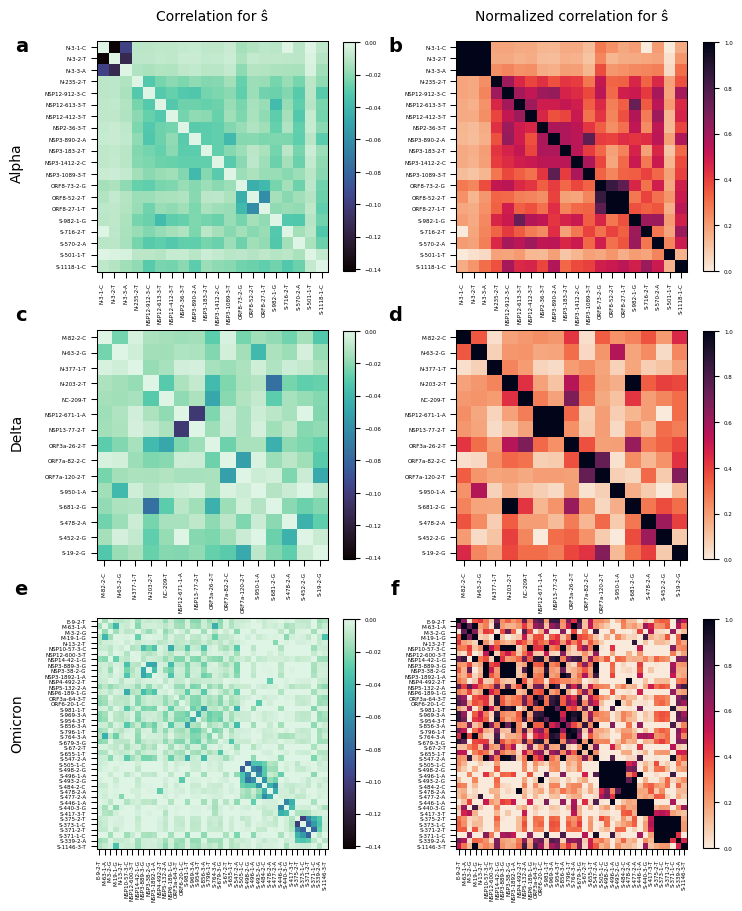

In [15]:
# Supplementary figure Z -- Matrix correlation plots

import epi_figs as ef
reload(ef)

cm_to_inch = lambda x: x/2.54
DOUBLE_COLUMN_WIDTH = cm_to_inch(19)

alpha_cor    = os.path.join(SARS_DATA_DIR, f'alpha-correlation-{INFERENCE_DATE}.csv')
alpha_norm   = os.path.join(SARS_DATA_DIR, f'alpha-correlation-normed-{INFERENCE_DATE}.csv')
delta_cor    = os.path.join(SARS_DATA_DIR, f'delta-correlation-{INFERENCE_DATE}.csv')
delta_norm   = os.path.join(SARS_DATA_DIR, f'delta-correlation-normed-{INFERENCE_DATE}.csv')
omicron_cor  = os.path.join(SARS_DATA_DIR, f'omicron-correlation-{INFERENCE_DATE}.csv')
omicron_norm = os.path.join(SARS_DATA_DIR, f'omicron-correlation-normed-{INFERENCE_DATE}.csv')
params = {
    'files'    : [[alpha_cor,     alpha_norm], 
                  [delta_cor,     delta_norm],
                  [omicron_cor, omicron_norm]],
    'titles'   : ['Correlation for s\u0302', 'Normalized correlation for s\u0302'],
    'variants' : ['Alpha', 'Delta', 'Omicron'],
    'figsize'  : [DOUBLE_COLUMN_WIDTH, DOUBLE_COLUMN_WIDTH * 1.2],
    'out'      : 'fig-s15-matrices'
}

ef.matrix_multiplot_new(**params)